In [1]:
import re 
import os 

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

In [2]:
class file: 
    
    def __init__(self, demo_file, health_file, year_str): 
        self.name = year_str 
        self.demo = demo_file 
        self.health = health_file
        
    def __repr__(self):
        return self.name
    
    __str__ = __repr__ 
    
    @property
    def weighted_insurance(self):
        return self.weight['WTINT2YR'] * self.covered
    
    @property
    def unweighted_insurance(self):
        return self.covered
    
    @property
    def covered(self):
        return self.health['HIQ011'] if 'HIQ011' in self.health.columns else self.health['HID010']
    
    @property
    def weight(self):
        return self.demo[['RIDAGEYR', 'WTINT2YR']]
    
    def __getitem__(self): 
        return self.health

def weighted_value(source_col, weight_col, percentage=True):
    unique_values = source_col.unique()
    mapping_dict = {}
    
    for value in unique_values: 
        binary = source_col == value
        weighted = binary * weight_col
        result = round(weighted.sum() / weight_col.sum(), 5) if percentage else weighted.sum()
        mapping_dict[value] = result
    return mapping_dict

year_mapping = {letter: f'{year}-{year+1}' for year, letter in enumerate('A B C D E F G H I J K L', 1999)}

In [3]:
records = [] 

year_regex = re.compile(r'.*_([A-Z]{1}).*')

files = list(filter(lambda item: item.endswith('XPT'), os.listdir('data')))
files.sort(key=lambda item: year_regex.search(item).groups()[0])

for index in range(0, len(files), 2):
    filename1, filename2 = files[index], files[index+1]
    year = year_mapping[year_regex.search(filename1).groups()[0]]
    file1, file2 = pd.read_sas(f'data/{filename1}'), pd.read_sas(f'data/{filename2}')
    package = (file1, file2) if 'DEMO' in filename1 else (file2, file1)
    package = file(*package, year)
    package.weighted_insurance
    records.append(package)

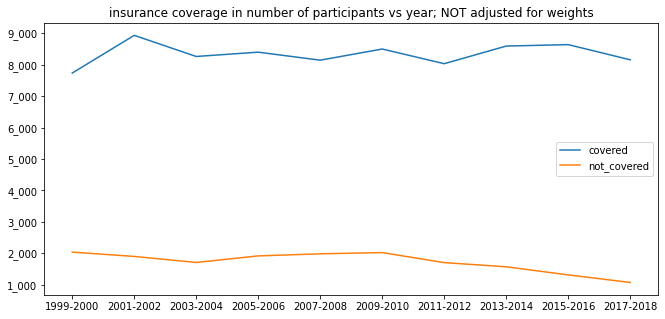

In [4]:
ticks = np.arange(1e3, 1e4, 1e3)
overall = []
for year_file in records: 
    equan_weights = pd.Series([1 for _ in range(year_file.weight.shape[0])])
    result = weighted_value(year_file.covered, equan_weights, percentage=False)
    covered, not_covered = result[1.0], result[2.0]
    overall.append([covered, not_covered, year_file.name])
overall = pd.DataFrame(columns=['covered', 'not_covered', 'year'], data=overall)    
    
plt.figure(figsize=(11, 5))
plt.plot(overall.index, overall['covered'], label='covered')
plt.plot(overall.index, overall['not_covered'], label='not_covered')
plt.xticks(overall.index, overall['year'])
plt.yticks(ticks, [f'{int(value):_}' for value in ticks])
plt.title('insurance coverage in number of participants vs year; NOT adjusted for weights')
plt.legend()
plt.show()

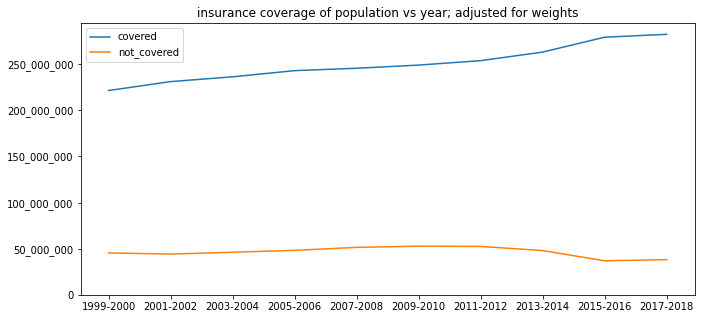

In [5]:
ticks = np.arange(0, 3e8, 5e7)
overall = []
for year_file in records: 
    result = weighted_value(year_file.covered, year_file.weight['WTINT2YR'], percentage=False)
    covered, not_covered = result[1.0], result[2.0]
    overall.append([covered, not_covered, year_file.name])
overall = pd.DataFrame(columns=['covered', 'not_covered', 'year'], data=overall)    
    
plt.figure(figsize=(11, 5))
plt.plot(overall.index, overall['covered'], label='covered')
plt.plot(overall.index, overall['not_covered'], label='not_covered')
plt.xticks(overall.index, overall['year'])
plt.yticks(ticks, [f'{int(value):_}' for value in ticks])
plt.title('insurance coverage of population vs year; adjusted for weights')
plt.legend()
plt.show()

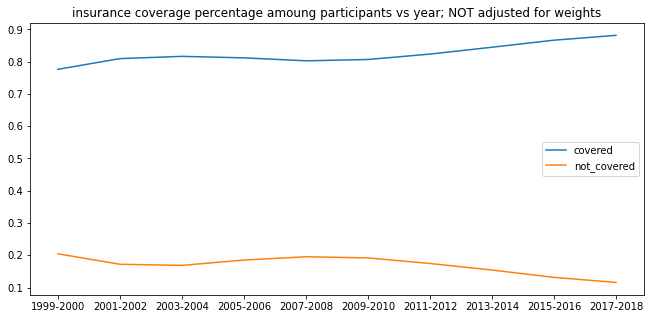

In [6]:
overall = []
for year_file in records: 
    equan_weights = pd.Series([1 for _ in range(year_file.weight.shape[0])])
    result = weighted_value(year_file.covered, equan_weights, percentage=True)
    covered, not_covered = result[1.0], result[2.0]
    overall.append([covered, not_covered, year_file.name])
overall = pd.DataFrame(columns=['covered', 'not_covered', 'year'], data=overall)    

    
plt.figure(figsize=(11, 5))
plt.plot(overall.index, overall['covered'], label='covered')
plt.plot(overall.index, overall['not_covered'], label='not_covered')
plt.xticks(overall.index, overall['year'])
plt.title('insurance coverage percentage amoung participants vs year; NOT adjusted for weights')
plt.legend()
plt.show()

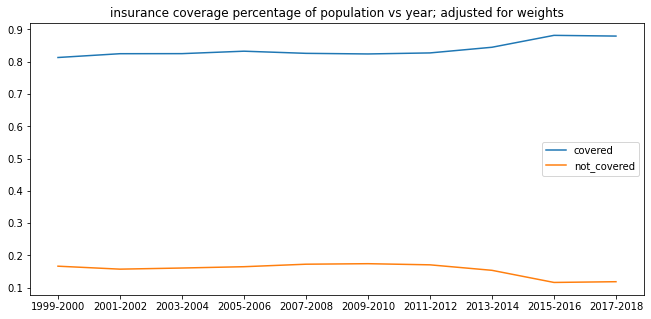

In [7]:

overall = []
for year_file in records: 
    result = weighted_value(year_file.covered, year_file.weight['WTINT2YR'], percentage=True)
    covered, not_covered = result[1.0], result[2.0]
    overall.append([covered, not_covered, year_file.name])
overall = pd.DataFrame(columns=['covered', 'not_covered', 'year'], data=overall)    

    
plt.figure(figsize=(11, 5))
plt.plot(overall.index, overall['covered'], label='covered')
plt.plot(overall.index, overall['not_covered'], label='not_covered')
plt.xticks(overall.index, overall['year'])
plt.title('insurance coverage percentage of population vs year; adjusted for weights')
plt.legend()
plt.show()

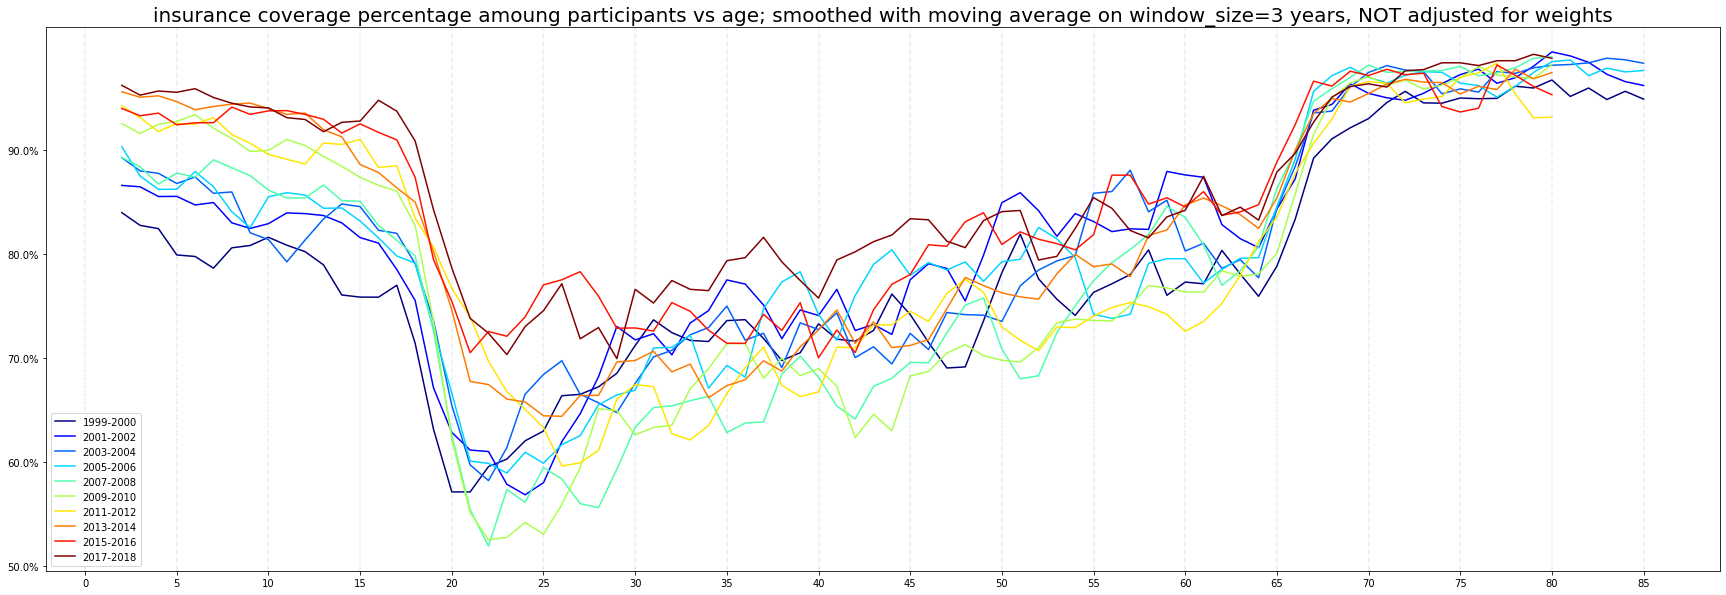

In [8]:
overall = pd.DataFrame(columns=['age', 'covered', 'year'])    
cmap = plt.cm.jet(np.linspace(0, 1, len(records)))

# age, covered, year 
for year_file in records: 
    result = pd.DataFrame() 
    result['age'] = year_file.demo['RIDAGEYR']
    result['covered'] = (year_file.covered==1.0) * 1
    result['not_covered'] = (year_file.covered==2.0) * 1
    
    formatted = result.groupby(by='age')[['covered', 'not_covered']].sum().reset_index(drop=False)
    populatoin = year_file.demo[['RIDAGEYR']].copy()
    population = populatoin.groupby(by='RIDAGEYR')['RIDAGEYR'].count().to_frame()
    population.columns = ['count']
    population.reset_index(drop=False, inplace=True)
    formatted['year'] = year_file.name
    formatted['age'] = formatted['age'].astype(int)
    formatted['covered'] = formatted['covered'] / population['count']
    formatted['not_covered'] = formatted['not_covered'] / population['count']
    overall = pd.concat([overall, formatted], axis=0, ignore_index=True)

moving_window = 3
plt.figure(figsize=(30, 10))
for index, year in enumerate(overall['year'].unique()):
    current_year = overall.loc[overall['year']==year].copy()
    current_year['moving'] = current_year['covered'].rolling(window=moving_window).mean()
    plt.plot(current_year['age'], current_year['moving'], label=year, color=cmap[index])

for value in range(0, 90, 5):
    plt.axvline(value, alpha=0.1, linestyle='--')
    
ticks = np.arange(0.5, 1, 0.1)
plt.xticks(range(0, 90, 5))
plt.yticks(ticks, [f'{round(value, 2) * 100}%' for value in ticks])
plt.title(f'insurance coverage percentage amoung participants vs age; smoothed with moving average on window_size={moving_window} years, NOT adjusted for weights', fontdict={'fontsize':20})
plt.legend()
plt.show()

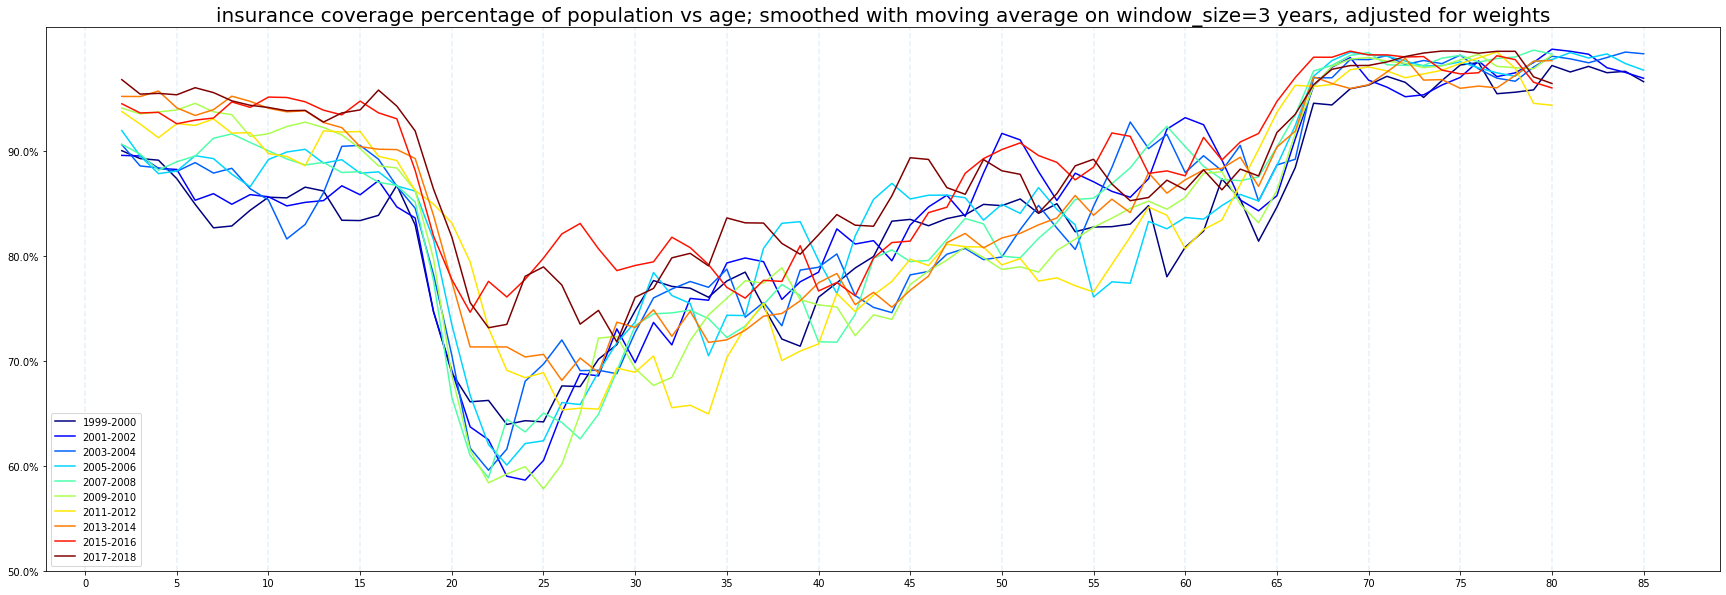

In [9]:
overall = pd.DataFrame(columns=['age', 'covered', 'year'])    
cmap = plt.cm.jet(np.linspace(0, 1, len(records)))

# age, covered, year 
for year_file in records: 
    result = pd.DataFrame() 
    result['age'] = year_file.demo['RIDAGEYR']
    result['covered'] = (year_file.covered==1.0) * year_file.weight['WTINT2YR']
    result['not_covered'] = (year_file.covered==2.0) * year_file.weight['WTINT2YR']
    
    formatted = result.groupby(by='age')[['covered', 'not_covered']].sum().reset_index(drop=False)
    population = year_file.weight.groupby(by='RIDAGEYR')['WTINT2YR'].sum().reset_index(drop=False)
    formatted['year'] = year_file.name
    formatted['age'] = formatted['age'].astype(int)
    formatted['covered'] = formatted['covered'] / population['WTINT2YR']
    formatted['not_covered'] = formatted['not_covered'] / population['WTINT2YR']
    overall = pd.concat([overall, formatted], axis=0, ignore_index=True)

moving_window = 3
plt.figure(figsize=(30, 10))
for index, year in enumerate(overall['year'].unique()):
    current_year = overall.loc[overall['year']==year].copy()
    current_year['moving'] = current_year['covered'].rolling(window=moving_window).mean()
    plt.plot(current_year['age'], current_year['moving'], label=year, color=cmap[index])

for value in range(0, 90, 5):
    plt.axvline(value, alpha=0.1, linestyle='--')
    
ticks = np.arange(0.5, 1, 0.1)
plt.xticks(range(0, 90, 5))
plt.yticks(ticks, [f'{round(value, 2) * 100}%' for value in ticks])
plt.title(f'insurance coverage percentage of population vs age; smoothed with moving average on window_size={moving_window} years, adjusted for weights', fontdict={'fontsize':20})
plt.legend()
plt.show()